In [91]:
import sys
print(sys.executable)


/home/michieletto/venv_pmerc/bin/python


In [92]:
# !pip install transformers   #Installare libreria transformers per usare librerie di Bert
# !pip install pandas
# !pip install torch
# !pip install scipy
# !pip install scikit-learn
# !pip install ipywidgets
# !pip install matplotlib


In [93]:
import sys

sys.path.append('/home/michieletto/hmp_utils')
if '../' not in sys.path:
    sys.path.append('../')

In [94]:
import json
import glob
import os
import random

from hmp_utils.motion.body_models_constants import SmplConstants
from hmp_utils.motion.mocap_processor import MocapLoader
from hmp_utils.motion.kinematics import ForwardKinematics
from hmp_utils.visualize.stickman_animation import pose_animation, CameraOrientation, AnimationMode

import torch
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import tqdm
import numpy as np
import pandas as pd
import time

 Creazione del dataset di Bert: dizionario con tutte le informazioni contenute nei file

In [95]:
dataset = []

# Definisci il percorso completo del file JSON
percorso_file_train = '/home/michieletto/datasets/BABEL_DATASET/babel_v1.0_release/train.json'
percorso_file_val   = '/home/michieletto/datasets/BABEL_DATASET/babel_v1.0_release/val.json'
percorso_file_test  = '/home/michieletto/datasets/BABEL_DATASET/babel_v1.0_release/test.json'

dataset.append(percorso_file_train)
dataset.append(percorso_file_val)
dataset.append(percorso_file_test)

data = {}           # Dizionario contenente l'intero dataset  

# Apre il file JSON in modalità lettura
for i,percorso_file in enumerate(dataset):
    with open(percorso_file, 'r') as f:
        # Carica i dati JSON
        data.update(json.load(f))


Estrazione dal dataset delle informzaioni essenziali: raw_label e feat_p (percorso file)

In [96]:

occur_lab = {
    'label': [],              
    'feat_p': []
    }

no_lab = 0

# Creazione del dataset contenente tutte le raw_label, passaggi cartelle e le action
for i, k in enumerate(data.keys()):
    label = data[k]["seq_ann"]["labels"][0]["raw_label"]
    feat_p = data[k]["feat_p"]

    if label is not None:
        occur_lab["label"].append(label)
        occur_lab["feat_p"].append(feat_p)
    else:
        no_lab += 1
            

print("Dati totali: ", len(data))
print("Dati con label: ", len(occur_lab["label"]))
print("Dati senza label:", no_lab)
print("num label, paths:", len(occur_lab["label"]), len(occur_lab["feat_p"]))


Dati totali:  10892
Dati con label:  8808
Dati senza label: 2084
num label, paths: 8808 8808


Creazione del dataset Amass ed estrazione random di un file per verificare se e come viene descritto da Babel (valutando se i percorsi file /ultima_cartella/nome_file.npz corrispondono)

In [97]:

directory = '/home/michieletto/datasets/AMASS_H/ACCAD'
file_paths = glob.glob(directory + '/**/*.npz', recursive=True) # ottiene tutti i file nelle diverse cartelle contenenti i mocap in una stringa

directory = '/home/michieletto/datasets/AMASS_H/KIT'
file_paths += glob.glob(directory + '/**/*.npz', recursive=True)

file_paths = sorted(file_paths)
print(len(file_paths))

rand_x = random.randint(0, len(file_paths))
filepath = file_paths[rand_x]

file_name = os.path.basename(filepath)    # ottiene il nome del file
folder_path = os.path.dirname(filepath)   # ottiene il percorso fino alla cartella in cui è contenuto il file
last_folder_name = os.path.basename(folder_path)     # ottiene il nome dell'ultima cartella
last_folder_and_file_name = os.path.join('/', last_folder_name, file_name)     # unisce i due nomi

for i in range(len(occur_lab["feat_p"])):
    if last_folder_and_file_name in occur_lab["feat_p"][i]:
        print(occur_lab["label"][i], occur_lab["feat_p"][i], last_folder_and_file_name)



4484


Creazione del MocapLoader ed estrazione dai file di Amass i frame in forma di matrici 24x3. Successivamente c'è la visualizzazione del primo frame del mocap estratto precedentemente ed il suo viedo.

In [98]:

frame_to_plot = 1

# -- load mocap --
mocap_loader=MocapLoader(body_model_type=SmplConstants.BODY_MODEL_TYPE,
                         keypoint_ids_to_load=SmplConstants.KEYPOINTS,
                         target_framerate = 25)

motions = []
motions = [mocap_loader.load_mocap(path) for path in file_paths]     # lista delle classi di tutti i mocap
motion = motions[rand_x]     # selezione casuale di un mocap
assert motion is not None

# -- compute joint positions --
kine = ForwardKinematics(SmplConstants.OFFSETS, SmplConstants.PARENTS)
kine.set_body_model_type(SmplConstants.BODY_MODEL_TYPE)

all_keypoints_positions = []
for motion in motions:
    if motion is not None:
        all_keypoints_positions.append(kine.compute_fk(motion.rots, apply_root_rotation=True))

# all_keypoints_positions = [kine.compute_fk(motion.rots, apply_root_rotation=True) for motion in motions]
keypoints_positions = all_keypoints_positions[rand_x][frame_to_plot]
print(len(all_keypoints_positions))

# -- plot --
# plot_body_keypoints(keypoints_positions, SmplConstants.PARENTS, azimuth=0, keypoint_size = 5, link_size=1, 
#                     show_keypoint_id=True, body_rotation=(0,0,45))

4483


In [99]:
keypoints_positions = all_keypoints_positions[rand_x][:250]
print(keypoints_positions.shape)

motions_list = [keypoints_positions]
subplot_ids = [0]
subplot_titles = ['Amass']
camera_orientations = [CameraOrientation(100, 20)]
# pose_animation(motions_list, SmplConstants.PARENTS, animation_framerate = 25, subplot_ids=subplot_ids, 
#                camera_orientations=camera_orientations, subplot_titles=subplot_titles,
#                fig_opts={'dpi':90}, animation_mode=AnimationMode.HTML)

(147, 24, 3)


Estrazione dall'intero dataset di Amass di 75 frame per mocap e ridimensionamento di questi da 24x3 a 72.

In [100]:
frame_vocab = []
deleted_paths = []

cont = 0
for i in range(len(motions)):
    if motions[i] is not None:
        if len(motions[i].rots) >= 75:
            rand_x = random.randint(0, len(motions[i].rots) - 75)
            frame_vocab.append(motions[i].rots[rand_x:rand_x + 75])
            assert len(frame_vocab[-1]) == 75

            frame_vocab[-1] = [[angle for k_point in frame for angle in k_point] for frame in frame_vocab[-1]]
            assert len(frame_vocab[-1][0]) == 72
        else:
            frame_vocab.append([])
            deleted_paths.append(i)
            cont +=1
    else:
        frame_vocab.append([])
        deleted_paths.append(i)
        cont += 1


sum = 0
for i in range(len(frame_vocab)):
    sum += len(frame_vocab[i])

print(f"Numero di mocap non validi: {cont}")
print(f"Il numero totale di frame è: {sum}")

Numero di mocap non validi: 131
Il numero totale di frame è: 326475


In [101]:
dataset = {
    'pose': [],
    'description': [],
}

for i in range(len(file_paths)):
    if i not in deleted_paths:
        filepath = file_paths[i]

        file_name = os.path.basename(filepath)    # ottiene il nome del file
        folder_path = os.path.dirname(filepath)   # ottiene il percorso fino alla cartella in cui è contenuto il file
        last_folder_name = os.path.basename(folder_path)     # ottiene il nome dell'ultima cartella
        last_folder_and_file_name = os.path.join('/', last_folder_name, file_name)     # unisce i due nomi
        
        for j in range(len(occur_lab["feat_p"])):
            if last_folder_and_file_name in occur_lab["feat_p"][j]:
                dataset["pose"].append(frame_vocab[i])
                dataset["description"].append(occur_lab["label"][j])

dataset = pd.DataFrame(dataset)
dataset_copy = dataset.copy()

print(len(dataset['pose']), len(dataset['description']))


2726 2726


In [102]:
print(len(dataset["pose"][0]), len(dataset["pose"][0][0]))
print(len(dataset_copy["pose"][0]), len(dataset_copy["pose"][0][0]))

75 72
75 72


In [103]:
# Funzione per eliminare una colonna da ogni matrice
def elimina_colonna(matrice, indexes_to_exclude):

    return [np.delete(row, indexes_to_exclude) for row in matrice]

indexes_to_exclude = [0,1,2, 30,31,32, 33,34,35, 66,67,68, 69,70,71] # Indici corrispondenti ai keypoint 0,10,11,22,23
# Applica la funzione a ogni elemento del DataFrame
dataset["pose"] = dataset["pose"].apply(elimina_colonna, indexes_to_exclude = indexes_to_exclude)

# indexes_to_exclude = [0,1,2, 30,31,32, 33,34,35, 66,67,68, 69,70,71] # Indici corrispondenti ai keypoint 0,10,11,22,23

# for i in range(len(dataset["pose"])):
#     for j in range(len(dataset.iloc[i]["pose"])):
#         dataset.iloc[i]["pose"][j] = [item for idx, item in enumerate(dataset.iloc[i]["pose"][j]) if idx not in indexes_to_exclude]
#         assert len(dataset.iloc[i]["pose"][j]) == 57

In [104]:
print(len(dataset["pose"][0]), len(dataset["pose"][0][0]))
print(len(dataset_copy["pose"][0]), len(dataset_copy["pose"][0][0]))

75 57
75 72


Divisione del dataset

In [105]:
# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
print(len(dataset["pose"][0]), len(dataset["pose"][0][0]))
# Dataset Amass
# train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=RANDOM_SEED)
# valid_data, test_data = train_test_split(test_data, test_size=0.5, random_state=RANDOM_SEED)

# print(len(train_data["pose"][0]), len(train_data["pose"][0][0]))
# print(len(dataset_copy["pose"][0]), len(dataset_copy["pose"][0][0]))


75 57


Data preprocessing

In [106]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Store length of each review
token_lens = []

# Iterate through the content slide
for txt in dataset["description"]:
    tokens = tokenizer.encode(txt, max_length=512)  #Capire la scelta del numero
    token_lens.append(len(tokens))

MAX_LEN = 10

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Creazione dei dataloader per il dataset considerando le label

In [107]:
class GPLabelDataset(Dataset):
    # Constructor Function
    def __init__(self, pose, labs, tokenizer, max_len):
        self.pose = pose
        self.labs = labs
        self.tokenizer = tokenizer
        self.max_len = max_len

    # Length magic method
    def __len__(self):
        return len(self.labs)

    # get item magic method
    def __getitem__(self, item):
        lab = str(self.labs[item])
        pose = self.pose.iloc[item]
        
        # Encoded format to be returned
        encoding = self.tokenizer.encode_plus(
            lab,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'pose': pose,
            'raw_label': lab,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
        }

Creazione dei dataloader per il dataset considerando le pose

In [108]:
def get_collate_fn():
    def collate_fn(batch):
        # Il batch si presenta come una lista di 32 dizionari, ognuno dei quali ha 4 chiavi: pose, raw_label, 
        # input_id e attention_mask. La posa inoltre è una matrice 75x72. Voglio quindi convertire gli ordini
        # in cui il batch sia un dizionario di 4 chiavi in ognuna delle quali ci sono tutte le informazioni raccolte insieme.
        reformed_batch = {
            'pose': [],
            'raw_label': [],
            'input_ids': [],
            'attention_mask': []
        }
        
        for i in range(len(batch)):
            reformed_batch["pose"].append(batch[i]["pose"])
            reformed_batch["raw_label"].append(batch[i]["raw_label"])
            reformed_batch["input_ids"].append(batch[i]["input_ids"].tolist())
            reformed_batch["attention_mask"].append(batch[i]["attention_mask"].tolist())

        
        reformed_batch["input_ids"] = torch.tensor(reformed_batch["input_ids"])
        reformed_batch["attention_mask"] = torch.tensor(reformed_batch["attention_mask"])

        reformed_batch["pose"] = [[row[i] for row in reformed_batch["pose"]] for i in range(len(reformed_batch["pose"][0]))]
        reformed_batch["pose"] = np.array(reformed_batch["pose"])
        reformed_batch["pose"] = torch.tensor(reformed_batch["pose"])
        reformed_batch["pose"] = reformed_batch["pose"].float()
        
        return reformed_batch

    return collate_fn

In [109]:
def get_data_loader(dataset, batch_size, max_len, shuffle=False):
    dataset = GPLabelDataset( # al posto di dataset nell'originale c'era ds
        pose = dataset.pose,
        labs=dataset.description.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    collate_fn = get_collate_fn()

    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    
    return data_loader

In [110]:
batch_size = 64

# train_data_loader = get_data_loader(train_data, batch_size, MAX_LEN)
# valid_data_loader = get_data_loader(valid_data, batch_size, MAX_LEN)
# test_data_loader = get_data_loader(test_data, batch_size, MAX_LEN)

# batch = next(iter(train_data_loader))
# print(batch.keys())
# print(batch["pose"].shape)
# print(batch["input_ids"].shape)
# print(batch["attention_mask"].shape)



# Controllo che i batch non abbiano cambiato l'ordine delle pose
# print(batch[25][0][0].dtype, type(train_data.iloc[25]['pose'][0][0]))
# print((batch.permute(1, 0, 2))[25][0][50] == train_data.iloc[25]['pose'][0][50])

# print(((batch.permute(1, 0, 2))[25]).tolist() == train_data.iloc[25]['pose'])
# cont = 0
# a=0
# for batch in train_data_loader_pose:
#     for i in range(len(batch.permute(1, 0, 2))):
#         if ((batch.permute(1, 0, 2))[i]).tolist() == train_data.iloc[i+cont]['pose']:
#             a+=1
#     cont+=32
# print(a, len(train_data))


Costruzione rete RNN: Bert, Encoder e decoder

# Rete RNN

In [111]:

# Build the Sentiment Classifier class
class ActionClassifier(nn.Module): 

    # Constructor class
    def __init__(self):
        super(ActionClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.5)

    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        #  Add a dropout layer
        hidden = self.drop(pooled_output)
        return hidden

In [112]:
class Encoder(nn.Module):
    def __init__(self, dense_vector_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.LSTM(dense_vector_dim + 768, hidden_dim, n_layers, dropout=dropout)

    def forward(self, src):
        
        # src = [src length, batch size, dense_vector_dim]
        outputs, (hidden, cell) = self.rnn(src)
        # outputs = [src length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # outputs are always from the top hidden layer
        return hidden, cell

In [113]:
class Decoder(nn.Module):
    def __init__(self, dense_vector_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = dense_vector_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.LSTM(dense_vector_dim + 768, hidden_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, dense_vector_dim)

    def forward(self, input, hidden, cell):
        # input = [batch size, dense_vector_dim + 768]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # n directions in the decoder will both always be 1, therefore:
        # hidden = [n layers, batch size, hidden dim]
        # context = [n layers, batch size, hidden dim]
        input = input.unsqueeze(0)
        # input = [1, batch size, dense_vector_dim + 768]
        output, (hidden, cell) = self.rnn(input, (hidden, cell))
        # output = [seq length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # seq length and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, hidden dim]
        # hidden = [n layers, batch size, hidden dim]
        # cell = [n layers, batch size, hidden dim]
        prediction = self.fc_out(output.squeeze(0))
        # prediction = [batch size, output dim]
        input = input.squeeze(0)
        prediction = input[:, 0:57] + prediction
        
        return prediction, hidden, cell

In [114]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, actionclassifier, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.actionclassifier = actionclassifier
        self.device = device
        assert (
            encoder.hidden_dim == decoder.hidden_dim
        ), "Hidden dimensions of encoder and decoder must be equal!"
        assert (
            encoder.n_layers == decoder.n_layers
        ), "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, input_ids, attention_mask, teacher_forcing_ratio):
        # src = [src length, batch size, dense_vector_dim]
        # trg = [trg length, batch size, dense_vector_dim]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        batch_size = trg.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        desc_emb = self.actionclassifier(input_ids, attention_mask)
        
        desc_emb_en = desc_emb.unsqueeze(0).expand(src.size(0), desc_emb.size(0), desc_emb.size(1))

        src = torch.cat((src, desc_emb_en), dim=-1)

        # tensor to store decoder outputs
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]

        desc_emb_dec = desc_emb.unsqueeze(0).expand(trg.size(0), desc_emb.size(0), desc_emb.size(1))
        trg = torch.cat((trg, desc_emb_dec), dim=-1)

        input = src[-1, :]
        # input = [batch size, output_dim]
        for t in range(trg_length):
            # insert input token embedding, previous hidden and previous cell states
            # receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            # output = [batch size, output dim]
            # hidden = [n layers, batch size, hidden dim]
            # cell = [n layers, batch size, hidden dim]
            # place predictions in a tensor holding predictions for each token
            outputs[t] = output

            output = torch.cat((output, desc_emb_dec[t]), dim=-1)
            # outputs = [trg_lenght, batch_size, dense_vector_dim]
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            # get the highest predicted token from our predictions
            # top1 = output.argmax(1)
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else output
            # input = [batch size]
        
        return outputs

In [115]:

dense_vector_encoder_dim = 57 
dense_vector_decoder_dim = 57 
hidden_dim = 256
lr = 2e-5
n_layers = 1
encoder_dropout = 0
decoder_dropout = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# actionclassifier = ActionClassifier()

# encoder = Encoder(
#     dense_vector_encoder_dim,
#     hidden_dim,
#     n_layers,
#     encoder_dropout,
# )

# decoder = Decoder(
#     dense_vector_decoder_dim,
#     hidden_dim,
#     n_layers,
#     decoder_dropout,
# )

# model = Seq2Seq(encoder, decoder, actionclassifier, device).to(device)

In [116]:
# def init_weights(m):
#     for name, param in m.named_parameters():
#         nn.init.uniform_(param.data, -0.08, 0.08)

# model.apply(init_weights)

In [117]:
# Number of iterations
EPOCHS = 500

# Optimizer Adam
# optimizer = optim.Adam(model.parameters(), lr=2e-5)

# total_steps = len(train_data_loader) * EPOCHS

# scheduler = get_linear_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=0,
#     num_training_steps=total_steps
# )

In [118]:
def train_fn(
    model, data_loader, optimizer, clip, teacher_forcing_ratio, scheduler, device):
    model.train()
    epoch_loss = 0
    num_mocap = 0
    for batch in data_loader:
        src_lenght = 50
        trg_lenght = 25

        src = batch["pose"][:src_lenght].to(device)
        trg = batch["pose"][-trg_lenght:].to(device)
        # src = [src length, batch size, dense_vector_dim]
        # trg = [trg length, batch size, dense_vector_dim]

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        
        optimizer.zero_grad()
        output = model(src, trg, input_ids, attention_mask, teacher_forcing_ratio)
        # output = [trg length, batch size, dense_vector_dim]
        output_dim = output.shape[-1]
        output = output[:].view(-1, output_dim)
        # output = [trg length * batch size, dense_vector_dim]
        trg = trg[:].view(-1, output_dim)
        # trg = [trg length * batch size, dense_vector_dim]
        loss = torch.square(output - trg) # loss = criterion(output, trg)
        loss = torch.sum(loss)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()
        num_mocap += src.shape[1]

    return epoch_loss / num_mocap

In [119]:
def evaluate_fn(model, data_loader, device):
    model.eval()
    epoch_loss = 0
    num_mocap = 0
    with torch.no_grad():
        for batch in data_loader:
            src_lenght = 50
            trg_lenght = 25

            src = batch["pose"][:src_lenght].to(device)
            trg = batch["pose"][-trg_lenght:].to(device)
            # src = [src length, batch size, dense_vector_dim]
            # trg = [trg length, batch size, dense_vector_dim]

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            output = model(src, trg, input_ids, attention_mask, 0)  # turn off teacher forcing
            # output = [trg length, batch size, trg vocab size]
            output_dim = output.shape[-1]
            output = output[:].view(-1, output_dim)
            # output = [trg length * batch size, trg vocab size]
            trg = trg[:].view(-1, output_dim)
            # trg = [trg length * batch size]
            loss = torch.square(output - trg) # loss = criterion(output, trg)
            loss = torch.sum(loss)
            epoch_loss += loss.item()
            num_mocap += src.shape[1]

    return epoch_loss / num_mocap

In [120]:

clip = 1.0
teacher_forcing_ratio = 0

best_valid_loss = float("inf")
history = {
    "train_loss": [],
    "valid_loss": [],
    "losses": []
}

train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=RANDOM_SEED)
valid_data, test_data = train_test_split(test_data, test_size=0.5, random_state=RANDOM_SEED)

train_data_loader = get_data_loader(train_data, batch_size, MAX_LEN)
valid_data_loader = get_data_loader(valid_data, batch_size, MAX_LEN)
test_data_loader = get_data_loader(test_data, batch_size, MAX_LEN)

all_seeds = [434345, 434345, 232, 875434, 3232356, 42, 645332, 67789, 3426, 2354]
for i in range(10):
    # frame_vocab = frame_vocab.sample(frac=1).reset_index(drop=True)
    
    torch.manual_seed(all_seeds[i])

    actionclassifier = ActionClassifier()

    encoder = Encoder(
        dense_vector_encoder_dim,
        hidden_dim,
        n_layers,
        encoder_dropout,
    )

    decoder = Decoder(
        dense_vector_decoder_dim,
        hidden_dim,
        n_layers,
        decoder_dropout,
    )

    model = Seq2Seq(encoder, decoder, actionclassifier, device).to(device)

    optimizer = optim.Adam(model.parameters(), lr=2e-5)

    total_steps = len(train_data_loader) * EPOCHS

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    for epoch in tqdm.tqdm(range(EPOCHS)):
        train_loss = train_fn(
            model,
            train_data_loader,
            optimizer,
            clip,
            teacher_forcing_ratio,
            scheduler,
            device,
        )
        history["train_loss"].append(train_loss)

        valid_loss = evaluate_fn(
            model,
            valid_data_loader,
            device,
        )
        history["valid_loss"].append(valid_loss)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), "tut1-model.pt")
        # print(f"\tTrain Loss: {train_loss:7.3f}")
        # print(f"\tValid Loss: {valid_loss:7.3f}")

    history["losses"].append(best_valid_loss)
    print(f"Epoch {i+1}/10")
    print(best_valid_loss)
    best_valid_loss = float("inf")
    

  0%|          | 0/500 [00:00<?, ?it/s]/home/michieletto/venv_pmerc/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 500/500 [28:26<00:00,  3.41s/it] 


Epoch 1/10
22.522576524224473


100%|██████████| 500/500 [28:25<00:00,  3.41s/it] 


Epoch 2/10
22.522576524224473


100%|██████████| 500/500 [28:25<00:00,  3.41s/it] 


Epoch 3/10
22.376566792582416


100%|██████████| 500/500 [28:06<00:00,  3.37s/it] 


Epoch 4/10
22.673402108552256


100%|██████████| 500/500 [28:00<00:00,  3.36s/it] 


Epoch 5/10
22.649070655906595


100%|██████████| 500/500 [28:23<00:00,  3.41s/it] 


Epoch 6/10
22.52705802498283


100%|██████████| 500/500 [29:32<00:00,  3.54s/it] 


Epoch 7/10
22.630275628505608


100%|██████████| 500/500 [28:01<00:00,  3.36s/it] 


Epoch 8/10
22.60651137802627


100%|██████████| 500/500 [29:29<00:00,  3.54s/it] 


Epoch 9/10
22.205801492208963


100%|██████████| 500/500 [29:07<00:00,  3.49s/it] 

Epoch 10/10
22.787437243339344


In [127]:
print(history["losses"])

np.savez("/home/michieletto/Progetti_per_tesi/Progetto_RNN/Risultati/amass_babel_modificato.npz", tensor1=history["losses"])

[22.522576524224473, 22.522576524224473, 22.376566792582416, 22.673402108552256, 22.649070655906595, 22.52705802498283, 22.630275628505608, 22.60651137802627, 22.205801492208963, 22.787437243339344]


In [122]:
model.load_state_dict(torch.load("tut1-model.pt"))

test_loss = evaluate_fn(model, test_data_loader, device)

print(f"| Test Loss: {test_loss:.3f}")

| Test Loss: 20.724


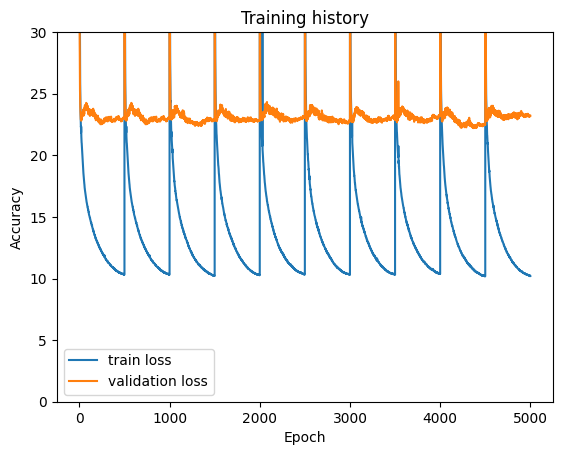

In [123]:
import matplotlib.pyplot as plt

#Plot training and validation accuracy
plt.plot(history["train_loss"], label='train loss')
plt.plot(history["valid_loss"], label='validation loss')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 30]);


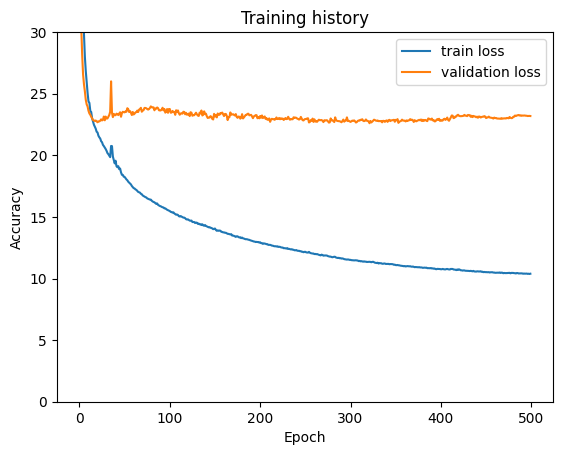

In [131]:
#Plot training and validation accuracy
plt.plot(history["train_loss"][3500:4000], label='train loss')
plt.plot(history["valid_loss"][3500:4000], label='validation loss')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 30]);

In [124]:
def prevision_mocap(model, input, device, max_output_length):
    model.eval()
    with torch.no_grad():
        input["pose"] = (torch.tensor(input["pose"]))
        input["pose"] = (input["pose"].float()).to(device)
        
        hidden, cell = model.encoder(input["pose"])
        previsions = input["pose"][-1].tolist()

        concat_hidden = model.actionclassifier(input["input_ids"].to(device), input["attention_mask"].to(device))
        concat_hidden = concat_hidden.unsqueeze(0)

        hidden = torch.cat((concat_hidden, hidden), dim=2).to(model.device)
        # hidden = [n layers * n directions, batch size, 2*hidden dim]
        concat_cell = torch.zeros(1, hidden.shape[1], 768).to(model.device)
        cell = torch.cat((concat_cell, cell), dim=2).to(model.device)
        # cell = [n layers * n directions, batch size, 2*hidden dim]

        for _ in range(max_output_length):
            inputs_tensor = torch.tensor([previsions[-1]]).to(device)

            output, hidden, cell = model.decoder(inputs_tensor, hidden, cell)
            output = output.tolist()
            previsions.append(output[0])
    
    del previsions[0]
    return np.array(previsions)


In [125]:
rand_x = random.randint(0, len(dataset_copy["pose"]))

input_mocap = np.array(dataset_copy["pose"][rand_x][:50])

deleted = input_mocap[:, indexes_to_exclude]

input_mocap_test = np.delete(input_mocap, indexes_to_exclude, axis=1)

expected_output_mocap = np.array(dataset_copy["pose"][rand_x][-25:])

test = {'pose': [input_mocap_test], 'description': [dataset_copy["description"][rand_x]]}
test = pd.DataFrame(test)
input_dataloader = get_data_loader(test, 1, MAX_LEN)

input = next(iter(input_dataloader))

prevision = prevision_mocap(
    model,
    input,
    device,
    max_output_length = expected_output_mocap.shape[0]
)

for i, column in enumerate(deleted[-25:].T):
    prevision = np.insert(prevision, indexes_to_exclude[i], column, axis=1)

input_mocap = input_mocap.reshape(50, 24, 3)
print(input_mocap.shape)

expected_output_mocap = expected_output_mocap.reshape(25, 24, 3)
print(expected_output_mocap.shape)

prevision = prevision.reshape(25, 24, 3)
print(prevision.shape)

/tmp/ipykernel_45723/1205961236.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input["pose"] = (torch.tensor(input["pose"]))


RuntimeError: input.size(-1) must be equal to input_size. Expected 825, got 57

In [ ]:

input_mocap = kine.compute_fk(input_mocap, apply_root_rotation=True)
expected_output_mocap = kine.compute_fk(expected_output_mocap, apply_root_rotation=True)
prevision = kine.compute_fk(prevision, apply_root_rotation=True)

motions_list = [[input_mocap], [expected_output_mocap, prevision]]
subplot_ids = [[0], [0,1]]
subplot_titles = [['Input_mocap'], ['Expected_output_mocap', 'Prevision']]
camera_orientations = [[CameraOrientation(100, 20)], [CameraOrientation(100, 20), CameraOrientation(100, 20)]]

pose_animation(motions_list[0], SmplConstants.PARENTS, animation_framerate = 25, subplot_ids=subplot_ids[0], 
               camera_orientations=camera_orientations[0], subplot_titles=subplot_titles[0],
               fig_opts={'dpi':90}, animation_mode=AnimationMode.HTML)

pose_animation(motions_list[1], SmplConstants.PARENTS, animation_framerate = 25, subplot_ids=subplot_ids[1], 
               camera_orientations=camera_orientations[1], subplot_titles=subplot_titles[1],
               animation_mode=AnimationMode.HTML)